In [1]:
import os
dir_list = os.chdir('./../reverse-dynamics-nlp/')

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, GPTNeoXForCausalLM
from prompt_optimizer import PromptOptimizer
from utils import get_reverse_pair, start_chunk_hf, forward_loss, reverse_normalized_generate, reverse_tokenize, reverse_decode
from tqdm import tqdm

/ext3/miniconda3/envs/slacktokens/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from typing import Callable, Iterable, Any
# def get_reverse_pair(dataset: Iterable[Any], chunk_func: Callable[..., Any], tokenizer: AutoTokenizer):
#     for chunk in dataset:
#         for chunk in chunk_func(chunk, tokenizer):
#             yield chunk

# def end_chunk_hf(chunk, tokenizer):
#     chunk = chunk['text']
#     tokens = tokenizer(chunk[-200:])['input_ids'][2:] #drop first couple tokens given risk of incomplete token
#     yield tokenizer.decode(tokens[-40:-30]), tokenizer.decode(tokens[-30:])

# def start_chunk_hf(chunk, tokenizer, num_prefix_tokens=10, num_suffix_tokens=40):
#     chunk = chunk['text']
#     tokens = tokenizer(chunk[:200])['input_ids'] #drop first couple tokens given risk of incomplete token
#     yield tokenizer.decode(tokens[:num_prefix_tokens]), tokenizer.decode(tokens[num_prefix_tokens:num_prefix_tokens+num_suffix_tokens])

# def rand_init(seq_length: int, tokenizer):
#     return tokenizer.decode(torch.randint(0, tokenizer.vocab_size, (seq_length,)))

In [12]:
pile_test = load_dataset('json', data_files='/vast/work/public/ml-datasets/pile/test.jsonl')
tokenizer = AutoTokenizer.from_pretrained("afterless/reverse-pythia-160m")

Found cached dataset json (/home/jp6263/.cache/huggingface/datasets/json/default-837f6abdcef3ff93/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 192.97it/s]


In [ ]:
def get_token_probabilities(tokenizer, dataset="NeelNanda/pile-10k", vocab_size=50304, split='train'):
    if type(dataset)==str:
        data = load_dataset(dataset)
    else:
        data = dataset
    counts = torch.zeros(vocab_size, dtype=torch.float) #tokenizer.vocab_size is fake 50304 is the model output dimension which is what we care about

    for chunk in data[split]:
        text = chunk['text']
        tokens = tokenizer(text, return_tensors="pt").input_ids[0]
        token_counts = torch.bincount(tokens, minlength=counts.size(0))
        counts += token_counts

    total_tokens = torch.sum(counts)
    probabilities = counts / total_tokens
    min_val = probabilities[probabilities > 0].min()
    probabilities[probabilities == 0] = min_val
    return probabilities

def get_pos_token_probabilities(tokenizer, dataset="NeelNanda/pile-10k", vocab_size=50304, split='train', prefix=10):
    if type(dataset)==str:
        data = load_dataset(dataset)
    else:
        data = dataset
    counts = torch.zeros((vocab_size,prefix), dtype=torch.float) #tokenizer.vocab_size is fake 50304 is the model output dimension which is what we care about


    for chunk in data[split]:
        # Extract text from chunk (assuming each chunk is a dictionary with a "text" key)
        text = chunk['text']

        # Tokenize the text
        tokens = tokenizer(text, return_tensors="pt").input_ids[0]
        tokens = tokens[:prefix]

        # Count occurrences for each token
        for t, tok in enumerate(tokens):
            counts[tok,t] += 1

    # Normalize the counts to get probabilities
    total_tokens = torch.sum(counts)
    probabilities = counts / total_tokens
    min_val = probabilities[probabilities > 0].min()
    probabilities[probabilities == 0] = min_val
    return probabilities

In [43]:
def get_pos_token_probabilities(tokenizer, dataset="NeelNanda/pile-10k", vocab_size=50304, split='train', prefix=10, prev_counts=None):
    if type(dataset) == str:
        data = load_dataset(dataset)
    else:
        data = dataset
    if prev_counts is None:
        counts = torch.zeros((vocab_size, prefix), dtype=torch.float)
    else: 
        counts = prev_counts
    
    token_to_string_rough_bound = 10*prefix
    for chunk in data[split]:
        text = chunk['text']
        tokens = tokenizer(text[:token_to_string_rough_bound], return_tensors="pt").input_ids[0]
        tokens = tokens[:prefix]
        if len(tokens) < prefix:
            tokens = tokenizer(text, return_tensors="pt").input_ids[0][:prefix]
        for t,token in enumerate(tokens):
            counts[token,t] += 1
    return counts

In [45]:
prev_counts = None
for i in range(30):
    num = str(i).zfill(2)
    pile_train = load_dataset('json', data_files=f'/vast/work/public/ml-datasets/pile/train/{num}.jsonl')
    prev_counts = get_pos_token_probabilities(tokenizer, dataset=pile_train, split='train', prefix=10, prev_counts=prev_counts)
torch.save(prev_counts, 'pos_counts_10.pt')

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 286.20it/s]
Generating train split: 1217660 examples [00:43, 21157.89 examples/s]

tensor(0.7253)

In [29]:
sum(lens)/len(lens)

6.347984255725191

In [25]:
counts = torch.zeros(50304, dtype=torch.float)

for i in range(1000):
    text = pile_test['train'][i]['text']
    text_tokens = tokenizer(text[:100], return_tensors="pt").input_ids[0]
    # for tok in text_tokens:
    #     counts[tok] += 1
    # token_counts = torch.bincount(text_tokens, minlength=counts.size(0))
    # counts += token_counts

In [37]:
len(pile_test['train'])

214584

In [ ]:
pos_probs = get_pos_token_probabilities(tokenizer, dataset=pile_test, split='train', prefix=10)

In [11]:
dataset = load_dataset("NeelNanda/pile-10k")
tokenizer = AutoTokenizer.from_pretrained("afterless/reverse-pythia-160m")
pairs = get_reverse_pair(dataset['train'], start_chunk_hf, tokenizer)
print(next(pairs))
bwd_model = GPTNeoXForCausalLM.from_pretrained("afterless/reverse-pythia-160m").cuda()
model = GPTNeoXForCausalLM.from_pretrained("EleutherAI/pythia-160m", cache_dir='/scratch/jp6263/hf/models/').cuda()

Found cached dataset parquet (/home/jp6263/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


('It is done, and submitted. You can play', ' “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit')


KeyboardInterrupt: 

In [5]:
gcg = PromptOptimizer(model, tokenizer, n_proposals=128, n_epochs=250, n_top_indices=128, prefix_loss_weight=0.1)

In [64]:
tokenwise_acc = []
loss = []
temp = 5 #None for default GCG with uniform sampling
for p,pair in enumerate(pairs):
    if len(loss)==25: break
    if len(pair[0])<10 or len(pair[1])<10: continue
    prefix_loss,suffix_loss = forward_loss(model, pair)
    # if suffix_loss>2.1: continue #this is around 10th percentile of losses for 170m
    prefix, suffix = pair
    prefix_tokens = tokenizer.encode(prefix)
    len_prefix = len(tokenizer(prefix)['input_ids'])
    rand_prefix = rand_init(len_prefix, tokenizer)
    optimized_string = gcg.optimize(rand_prefix, suffix, temperature=temp)
    predicted_prefix_tokens = tokenizer.encode(optimized_string)[:len_prefix]
    predicted_prefix = tokenizer.decode(predicted_prefix_tokens)
    predicted_prefix_loss, predicted_suffix_loss = forward_loss(model, (predicted_prefix, suffix))
    print(f'True prefix is:\n{prefix} \n\nPredicted prefix:\n{predicted_prefix}\nfor suffix:\n {suffix}')
    print(f'Loss for suffix given predicted prefix is {predicted_suffix_loss.item()} \n Suffix loss for true prefix is {suffix_loss.item()}')
    print(f'NLL on predicted prefix is {predicted_prefix_loss.item()} \n NLL on true prefix is {prefix_loss.item()}')
    loss.append(predicted_suffix_loss.item())
    tokenwise_acc.append(sum([1 for i in range(len(prefix_tokens)) if prefix_tokens[i] == predicted_prefix_tokens[i]])/len(prefix_tokens))
print(f'Average tokenwise accuracy is {sum(tokenwise_acc)/len(tokenwise_acc)}')
print(f'Average loss is {sum(loss)/len(loss)}')

True prefix is:
When Rudy Gay left the game with a left 

Predicted prefix:
dden rebounds?” de sophomorening replay savage Kyle F
for suffix:
  knee injury late in the first quarter, memories of the Sacramento Kings’ (16-22) recent poor play minus a star resurfaced. The thought came to fruition as DeMar
Loss for suffix given predicted prefix is 3.7890825271606445 
 Suffix loss for true prefix is 3.94195556640625
NLL on predicted prefix is 11.186927795410156 
 NLL on true prefix is 5.150575637817383
True prefix is:
Three-dimensional structures of H-ras p21 

Predicted prefix:
empt MOS Xml Papers FulcraftsOnline Corp lipid
for suffix:
  mutants: molecular basis for their inability to function as signal switch molecules.
The X-ray structures of the guanine nucleotide binding domains (amino aci
Loss for suffix given predicted prefix is 3.5350232124328613 
 Suffix loss for true prefix is 3.7197718620300293
NLL on predicted prefix is 11.747693061828613 
 NLL on true prefix is 4.4457898139953

In [5]:
rlm_tokenwise_acc = []
rlm_loss = []
rlm_best_tokenwise_acc = []
rlm_best_loss = []
all_losses = []
rlm_greedy_loss = []
all_naturals = []
greedy_natural = []
pile_prefix_loss = []

dataset_gold_loss = []
dataset_p_temp = 0
# rlm_temp=0.01
rejection_sample = 5000
eval_size=10
len_prefix = 5
len_suffix = 15
pairs = get_reverse_pair(dataset['train'], lambda x, y: start_chunk_hf(x,y,num_prefix_tokens=len_prefix,num_suffix_tokens=len_suffix), tokenizer) #previously 10, 40

for p,pair in enumerate(tqdm(pairs)):
    if len(rlm_loss)==eval_size: break
    prefix_tokens = tokenizer.encode(pair[0])
    suffix_tokens = tokenizer.encode(pair[1])
    if len(prefix_tokens)<len_prefix or len(suffix_tokens)<len_suffix: continue
    prefix_loss,suffix_loss = forward_loss(model, pair, tokenizer)
    # if suffix_loss>2.1: continue #this is around 10th percentile of losses for 170m
    prefix, suffix = pair

    min_loss, min_prefix = float('inf'), None
    all_losses.append([])
    all_naturals.append([])
    # for t in range(rejection_sample):
        # predicted_prefix = reverse_normalized_generate(bwd_model, tokenizer, suffix, len_prefix, None, temperature=rlm_temp) # for temperature sampling with p(p) normalized probabilities
    outputs = bwd_model.generate(
        input_ids=reverse_tokenize(tokenizer, suffix),  
        max_length=len_prefix + len(tokenizer.encode(suffix)),
        num_beams=rejection_sample,  
        early_stopping=False,
        do_sample=False,  # Disable random sampling
        num_return_sequences=rejection_sample,  
    )
    for output in outputs:
        predicted_prefix_tokens = output[len_suffix:]
        predicted_prefix_tokens = list(predicted_prefix_tokens.cpu().numpy())[::-1]
        predicted_prefix = tokenizer.decode(predicted_prefix_tokens)
        predicted_prefix_loss, predicted_suffix_loss = forward_loss(model, (predicted_prefix, suffix), tokenizer)
        all_losses[-1].append(predicted_suffix_loss.item())
        all_naturals[-1].append(predicted_prefix_loss.item())
        if predicted_suffix_loss < min_loss:
            min_loss = predicted_suffix_loss
            min_prefix = predicted_prefix
            min_prefix_tokens = predicted_prefix_tokens

    # print(f'True prefix is:\n{prefix} \n\nPredicted prefix:\n{min_prefix}\nfor suffix:\n {suffix}')
    # print(f'Loss for suffix given predicted prefix is {min_loss.item()} \n Suffix loss for true prefix is {suffix_loss.item()}')
    # print(f'NLL on predicted prefix is {predicted_prefix_loss.item()} \n NLL on true prefix is {prefix_loss.item()}')

    pile_prefix_loss.append(prefix_loss.item())
    dataset_gold_loss.append(suffix_loss.item())
    rlm_tokenwise_acc.append(sum([1 for i in range(len(prefix_tokens)) if prefix_tokens[i] == predicted_prefix_tokens[i]])/len(prefix_tokens))
    rlm_loss.append(predicted_suffix_loss.item())
    rlm_best_tokenwise_acc.append(sum([1 for i in range(len(prefix_tokens)) if prefix_tokens[i] == min_prefix_tokens[i]])/len(prefix_tokens))
    rlm_best_loss.append(min_loss.item())

print(f'Average tokenwise accuracy is {sum(rlm_tokenwise_acc)/len(rlm_tokenwise_acc)}')
print(f'Average loss is {sum(rlm_loss)/len(rlm_loss)}')
print(f'Average dataset gold loss is {sum(dataset_gold_loss)/len(dataset_gold_loss)}')
print(f'Best tokenwise accuracy is {sum(rlm_best_tokenwise_acc)/len(rlm_best_tokenwise_acc)}')
print(f'Best loss is {sum(rlm_best_loss)/len(rlm_best_loss)}')

0it [00:00, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
1it [00:55, 55.79s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
2it [01:51, 55.85s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
3it [02:47, 55.83s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable resul

Average tokenwise accuracy is 0.14
Average loss is 3.296421158313751
Average dataset gold loss is 3.32355455160141
Best tokenwise accuracy is 0.16
Best loss is 2.7017696022987367


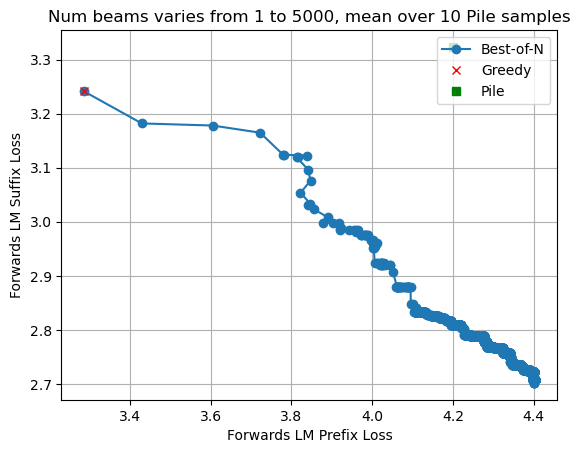

In [7]:
# Initialization
import matplotlib.pyplot as plt
import numpy as np

pile_suffix_loss = sum(dataset_gold_loss)/len(dataset_gold_loss)
pile_prefix_natural = sum(pile_prefix_loss)/len(pile_prefix_loss)

Ns = range(1, rejection_sample)
mean_natural_loss = []
best_of_N_loss = []

for N in Ns:
    mean_natural_loss.append(np.mean([np.mean(single_list[:N]) for single_list in all_naturals]))  # Assuming all_naturals is a list of lists
    best_of_N_loss.append(np.mean([min(single_list[:N]) for single_list in all_losses]))  # Assuming all_losses is a list of lists

# Plotting
plt.figure()
plt.plot(mean_natural_loss, best_of_N_loss, marker='o', label='Best-of-N')
plt.plot([mean_natural_loss[0]], [best_of_N_loss[0]], marker='x', linestyle='', color='red', label='Greedy')
plt.plot([pile_prefix_natural], [pile_suffix_loss], marker='s', linestyle='', color='green', label='Pile')
plt.xlabel(f'Forwards LM Prefix Loss')
plt.ylabel('Forwards LM Suffix Loss')
plt.title(f'Num beams varies from 1 to {rejection_sample}, mean over {eval_size} Pile samples')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

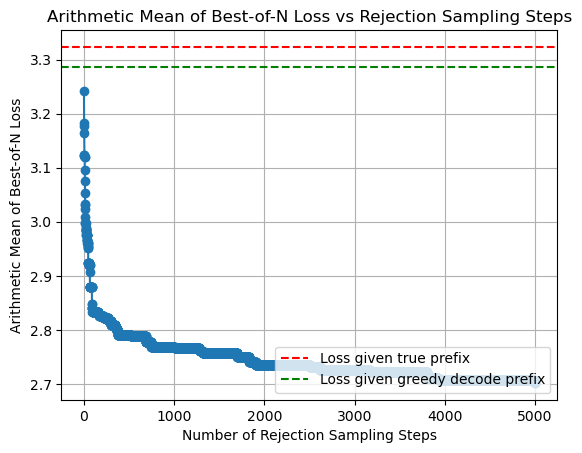

In [8]:


# Initialization
Ns = range(1, rejection_sample)
mean_best_of_N_loss = []

for N in Ns:
    best_of_N_loss = [min(single_list[:N]) for single_list in all_losses]
    mean_best_of_N_loss.append(np.mean(best_of_N_loss))

# Plotting
plt.figure()
plt.plot(Ns, mean_best_of_N_loss, marker='o')
plt.axhline(y=sum(dataset_gold_loss)/len(dataset_gold_loss), color='r', linestyle='--', label='Loss given true prefix')
plt.axhline(y=mean_natural_loss[0], color='g', linestyle='--', label='Loss given greedy decode prefix')
plt.xlabel('Number of Rejection Sampling Steps')
plt.ylabel('Arithmetic Mean of Best-of-N Loss')
plt.title('Arithmetic Mean of Best-of-N Loss vs Rejection Sampling Steps')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

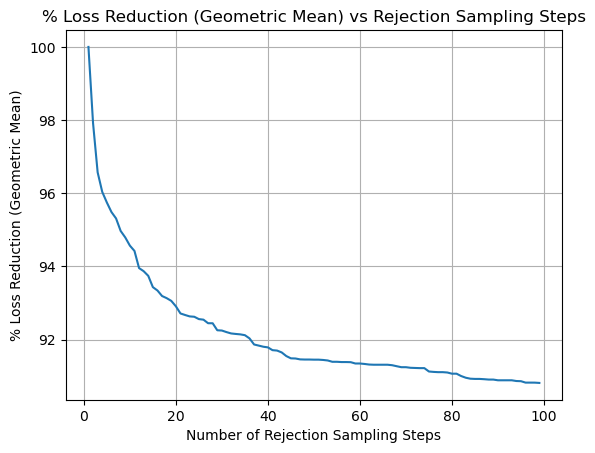

In [9]:
geometric_mean_reduction_per_step = []

for n in Ns:
    best_of_n_losses = [min(single_list[:n]) for single_list in all_losses]
    best_of_1_losses = [single_list[0] for single_list in all_losses]
    reduction_percentages = [best_of_n_losses[i] / best_of_1_losses[i] * 100 for i in range(len(best_of_n_losses))]
    geometric_mean_reduction = np.exp(np.mean(np.log(reduction_percentages)))  # Geometric mean formula
    geometric_mean_reduction_per_step.append(geometric_mean_reduction)

plt.plot(Ns, geometric_mean_reduction_per_step)
plt.xlabel('Number of Rejection Sampling Steps')
plt.ylabel('% Loss Reduction (Geometric Mean)')
plt.title('% Loss Reduction (Geometric Mean) vs Rejection Sampling Steps')
plt.grid(True)
plt.show()

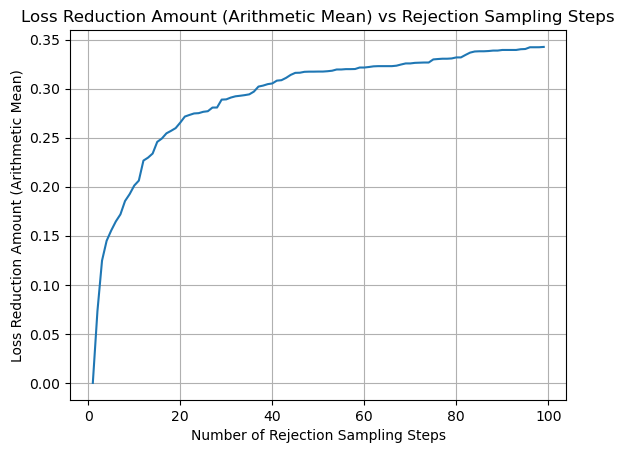

In [10]:
arithmetic_mean_reduction_per_step = []

for n in Ns:
    best_of_n_losses = [min(single_list[:n]) for single_list in all_losses]
    best_of_1_losses = [single_list[0] for single_list in all_losses]
    reduction_amounts = [best_of_1_losses[i] - best_of_n_losses[i] for i in range(len(best_of_n_losses))]
    arithmetic_mean_reduction = np.mean(reduction_amounts)
    arithmetic_mean_reduction_per_step.append(arithmetic_mean_reduction)

plt.plot(Ns, arithmetic_mean_reduction_per_step)
plt.xlabel('Number of Rejection Sampling Steps')
plt.ylabel('Loss Reduction Amount (Arithmetic Mean)')
plt.title('Loss Reduction Amount (Arithmetic Mean) vs Rejection Sampling Steps')
plt.grid(True)
plt.show()

Average loss is 3.585718604326248
Average dataset gold loss is 3.3005855083465576

3.2 with 0.25, 0
Average loss is 2.9196928358078003
Average dataset gold loss is 2.9133758544921875


In [144]:
tokenwise_acc = []
loss = []
for p,pair in enumerate(pairs):
    if len(loss)==100: break
    if len(pair[0])<10 or len(pair[1])<10: continue
    prefix_loss,suffix_loss = forward_loss(model, pair)
    if suffix_loss>2.1: continue #this is around 10th percentile of losses for 170m
    prefix, suffix = pair
    len_prefix = len(tokenizer(prefix)['input_ids'])
    predicted_prefix = reverse_generate(bwd_model, tokenizer, suffix, len_prefix)[0]
    predicted_prefix = tokenizer.decode(tokenizer.encode(predicted_prefix)[:len_prefix])

    predicted_prefix_loss, predicted_suffix_loss = forward_loss(model, (predicted_prefix, suffix))
    print(f'True prefix is:\n{prefix} \n\nPredicted prefix:\n{predicted_prefix}\nfor suffix:\n {suffix}')
    print(f'Loss for suffix given predicted prefix is {predicted_suffix_loss.item()} \n Suffix loss for true prefix is {suffix_loss.item()}')
    print(f'NLL on predicted prefix is {predicted_prefix_loss.item()} \n NLL on true prefix is {prefix_loss.item()}')
    loss.append(predicted_suffix_loss.item())
# print(f'Average tokenwise accuracy is {sum(tokenwise_acc)/len(tokenwise_acc)}')
print(f'Average loss is {sum(loss)/len(loss)}')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


True prefix is:
                                                                                  [PUBLISH]


                   

Predicted prefix:
           [DO NOT PUBLISH]


                IN
for suffix:
 IN THE UNITED STATES COURT OF APPEALS

                            FOR THE ELEVENTH CIRC
Loss for suffix given predicted prefix is 1.5578012466430664 
 Suffix loss for true prefix is 1.1715296506881714
NLL on predicted prefix is 5.3471269607543945 
 NLL on true prefix is 3.7086830139160156
True prefix is:
Mystikal (album)

My 

Predicted prefix:
 he said.Mystikal

My
for suffix:
 stikal is the eponymous self-titled debut studio album by American rapper Mystikal. It was independently self-released on June 14, 1994, by Big Boy Records. The
Loss for suffix given predicted prefix is 2.3714146614074707 
 Suffix loss for true prefix is 2.054072141647339
NLL on predicted prefix is 4.269046783447266 
 NLL on true prefix is 3.6076202392578125


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


True prefix is:
5. Let b be (-105)/(-10)* 

Predicted prefix:
*k. Let b be 4/2*
for suffix:
 6/k. Let y be (-3)/1 + (-196)/b. Solve -y = 4*u + 3*v, -2*v + 5*v = -2
Loss for suffix given predicted prefix is 1.522289514541626 
 Suffix loss for true prefix is 1.646061658859253
NLL on predicted prefix is 2.721585750579834 
 NLL on true prefix is 3.1036183834075928
True prefix is:
Hyperolius ferrugineus

Hyper 

Predicted prefix:
Hyperolius ferrugineus

Hyper
for suffix:
 olius ferrugineus is a species of frog in the family Hyperoliidae.
It is endemic to Democratic Republic of the Congo.
Its natural habitats are subtropical or tropical mois
Loss for suffix given predicted prefix is 1.979470133781433 
 Suffix loss for true prefix is 1.979470133781433
NLL on predicted prefix is 4.303708553314209 
 NLL on true prefix is 4.303708553314209


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


True prefix is:
Hatamabad, Markazi

H 

Predicted prefix:
 he said.Jatamabad

J
for suffix:
 atamabad (, also Romanized as Ḩātamābād) is a village in Farmahin Rural District, in the Central District of Farahan County, Markazi
Loss for suffix given predicted prefix is 1.5585622787475586 
 Suffix loss for true prefix is 1.4432446956634521
NLL on predicted prefix is 4.541042804718018 
 NLL on true prefix is 4.4801740646362305
True prefix is:
<?php defined('BX_DOL') 

Predicted prefix:
_BEFORE_HACK_PAUSE')
for suffix:
  or die('hack attempt');
/**
 * Copyright (c) UNA, Inc - https://una.io
 * MIT License - https://opensource.org/licenses/MIT
Loss for suffix given predicted prefix is 1.8252325057983398 
 Suffix loss for true prefix is 1.6047663688659668
NLL on predicted prefix is 4.435699462890625 
 NLL on true prefix is 4.108913421630859


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


True prefix is:
<header class="header-wrapper">

   

Predicted prefix:
>
<div class="container">
  
for suffix:
 <nav class="inner">
    <div class="title">
      <a href="/">
        <img class="logo" src="<%- url_for(theme.profile
Loss for suffix given predicted prefix is 1.8682317733764648 
 Suffix loss for true prefix is 1.8162084817886353
NLL on predicted prefix is 1.1058136224746704 
 NLL on true prefix is 2.780362367630005
True prefix is:
/*
Copyright (C) 2011 Mark Chandler ( 

Predicted prefix:
 part of the Desura(R) project (
for suffix:
 Desura Net Pty Ltd)
Copyright (C) 2014 Bad Juju Games, Inc.

This program is free software: you can redistribute it and/or modify
it under the
Loss for suffix given predicted prefix is 2.050963878631592 
 Suffix loss for true prefix is 1.5706523656845093
NLL on predicted prefix is 4.815761566162109 
 NLL on true prefix is 4.146985054016113


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


True prefix is:
The present invention relates to catalyst components for the polymerization 

Predicted prefix:
, to the use of said catalysts in the polymerization
for suffix:
  of olefins, to the catalysts obtained therefrom and to the use of said catalysts in the polymerization of olefins CH2xe2x95x
Loss for suffix given predicted prefix is 1.7928210496902466 
 Suffix loss for true prefix is 1.878375768661499
NLL on predicted prefix is 3.803551435470581 
 NLL on true prefix is 2.978477954864502
True prefix is:
1. Introduction {#sec1-ijerph-17 

Predicted prefix:
1. Introduction {#sec1-ijerph-17
for suffix:
 -01067}

Nasolacrimal duct obstruction (NLDO) is the most common cause of childhood epiphora \[[@B1-ijerph-17-010
Loss for suffix given predicted prefix is 1.7206493616104126 
 Suffix loss for true prefix is 1.7206493616104126
NLL on predicted prefix is 1.8608165979385376 
 NLL on true prefix is 1.8608165979385376
Average loss is 1.824743640422821


In [70]:
from utils import reverse_tokenize, reverse_decode
def reverse_normalized_forward(reverse_model, tokenizer, target, normalizer):
    inputs = reverse_tokenize(tokenizer, target)
    outputs = reverse_model(inputs).logits[0,-1,:]
    outputs = torch.nn.Softmax(dim=-1)(outputs).cpu()
    outputs = torch.mul(outputs, normalizer)
    return outputs

def reverse_normalized_generate(reverse_model, tokenizer, target, max_length, normalizer, temperature=1):
    prefix = []
    for i in range(max_length):
        normalized_probs = reverse_normalized_forward(reverse_model, tokenizer, ''.join(prefix[::-1]) + target, normalizer)
        if not temperature:
            token = tokenizer.decode(torch.argmax(normalized_probs))
        else:
            probs = torch.div(normalized_probs, temperature)
            probs = torch.nn.Softmax(dim=-1)(probs)
            token = tokenizer.decode(torch.multinomial(probs, num_samples=1))
        if token == '[PAD]' or token == '[EOS]':
            break
        prefix.append(token)
    return ''.join(prefix[::-1])+target

inverse_dataset_probs = torch.reciprocal(dataset_probs)
reverse_normalized_generate(bwd_model, tokenizer, ' on the mat next to the kitchen.', 5, inverse_dataset_probs**0.1, temperature=0)

' dish towel and set it on the mat next to the kitchen.'

In [156]:
tokenwise_acc = []
loss = []
for p,pair in enumerate(pairs):
    if len(loss)==250: break
    if len(pair[0])<10 or len(pair[1])<10: continue
    prefix_loss,suffix_loss = forward_loss(model, pair)
    # if suffix_loss>2.1: continue #this is around 10th percentile of losses for 170m
    prefix, suffix = pair
    len_prefix = len(tokenizer(prefix)['input_ids'])
    predicted_prefix = reverse_normalized_generate(bwd_model, tokenizer, suffix, len_prefix, inverse_dataset_probs**0.25, temperature=0) #1.425 at 0.25 partial Bayes update vs 1.437 at 0 i.e. default
    predicted_prefix = tokenizer.decode(tokenizer.encode(predicted_prefix)[:len_prefix])

    predicted_prefix_loss, predicted_suffix_loss = forward_loss(model, (predicted_prefix, suffix))
    # print(f'True prefix is:\n{prefix} \n\n')
    # print(f'Predicted prefix:\n{predicted_prefix}\nfor suffix:\n {suffix}')
    # print(f'Loss for suffix given predicted prefix is {predicted_suffix_loss.item()} \n Suffix loss for true prefix is {suffix_loss.item()}')
    # print(f'NLL on predicted prefix is {predicted_prefix_loss.item()} \n NLL on true prefix is {prefix_loss.item()}')
    loss.append(predicted_suffix_loss.item())
# print(f'Average tokenwise accuracy is {sum(tokenwise_acc)/len(tokenwise_acc)}')
print(f'Average loss is {sum(loss)/len(loss)}')

Average loss is 1.5034217107743024


In [44]:
def get_token_probabilities(tokenizer, dataset="NeelNanda/pile-10k", vocab_size=50304):
    data = load_dataset(dataset)
    counts = torch.zeros(vocab_size, dtype=torch.float) #tokenizer.vocab_size is fake 50304 is the model output dimension which is what we care about

    for chunk in data['train']:
        # Extract text from chunk (assuming each chunk is a dictionary with a "text" key)
        text = chunk['text']

        # Tokenize the text
        tokens = tokenizer(text, return_tensors="pt").input_ids[0]

        # Count occurrences for each token
        for tok in tokens:
            counts[tok] += 1

    # Normalize the counts to get probabilities
    total_tokens = torch.sum(counts)
    probabilities = counts / total_tokens
    min_val = probabilities[probabilities > 0].min()
    probabilities[probabilities == 0] = min_val
    return probabilities

dataset_probs = get_token_probabilities(tokenizer)

Found cached dataset parquet (/home/jp6263/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 297.19it/s]


In [117]:
reverse_generate(bwd_model, tokenizer, ' on the mat next to the kitchen.', 5,)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


[' it, and set it on the mat next to the kitchen.']

tensor(4.4364e-05)